## Overview:
We are using the CDC's 2009 H1n1 and Flu vaccine survey. We are looking to determine only whether or not respondents received the H1N1 vaccine and determining the relevant features of the train data.


### Now we look at the data to get a better idea of what we're working with

We have four files prepared for us already: training features and training labels, and test features and test labels.
We need to look at all our files, merge them, and then performing basic cleaning

### EDA

In [44]:
# imports

# basics and EDA 
import pandas as pd
import numpy as np
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
from string import ascii_letters
import seaborn as sns


# Preprocessing and scoring
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, MaxAbsScaler, MultiLabelBinarizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split as tts, KFold, cross_val_score, GridSearchCV, cross_validate
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay

# Pipelines
from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline, make_pipeline


# Models 
from catboost import Pool, CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier  # have to do all this because otherwise xgbooster kills the kernal
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier # didn't get a chance to try
from sklearn.multioutput import MultiOutputClassifier # didn't get a chance to try
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE


# Warnings, misc.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
train_features_1 = pd.read_csv('/Users/admin/Documents/Flatiron/H1_N1-Classification-Project/data/training_set_features.csv')
train_targets_1 = pd.read_csv('/Users/admin/Documents/Flatiron/H1_N1-Classification-Project/data/training_set_labels.csv')
test_features_1 = pd.read_csv('/Users/admin/Documents/Flatiron/H1_N1-Classification-Project/data/test_set_features.csv')


In [3]:
# Set display configuration
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

In [4]:
# Since we are not given our test labels data, we will have to create a master set and then create our own train_test_split


# Let's be through and see if our train features and targets are even the same length

np.testing.assert_array_equal(train_features_1.index.values, train_targets_1.index.values)

# no error, so they do match!
print(train_features_1.shape)
print(train_targets_1.shape)
print(test_features_1.shape)

# Hmm, it appears that perhaps the train and test features are in fact the same data, implying we do, in fact,
# need to merge and split fresh. Let's look closer

(26707, 36)
(26707, 3)
(26708, 36)


In [5]:
# Let's look  at the id numbers, which are pre-given to us as unique
train_features_1.columns
train_features_1['respondent_id'].value_counts()
test_features_1.columns
test_features_1['respondent_id'].value_counts()
train_features_1.assign(Intest_features_1=train_features_1.respondent_id.isin(test_features_1.respondent_id).astype(int))
# No, these all appear unique. let's be certain. 
print(train_features_1.respondent_id.isin(test_features_1.respondent_id).value_counts())

# Yes, they're all unique. so the data was just split in half between test and training


False    26707
Name: respondent_id, dtype: int64


In [6]:
# Looking over everything 

print(train_targets_1.info())
print(train_features_1.info())
print(test_features_1.info())


# Not too many nulls, but of those categories with a lot (health insurance, employment info), they seem pretty 
# important! It's well-understood that these are proxies in many cases for education, which correlates strongly with
# vaccine acceptance, at least in the US. however, there is an education category, so depending on how strong it is,
# we might be able to drop these categories, as they would cause multicollinearity. However, there is probably
# good data in those categories that we would not want to throw away. We would have to seriously consider how we would
# weight these. Imputation would likely not be an ideal strategy, but we may have no choice. 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null 

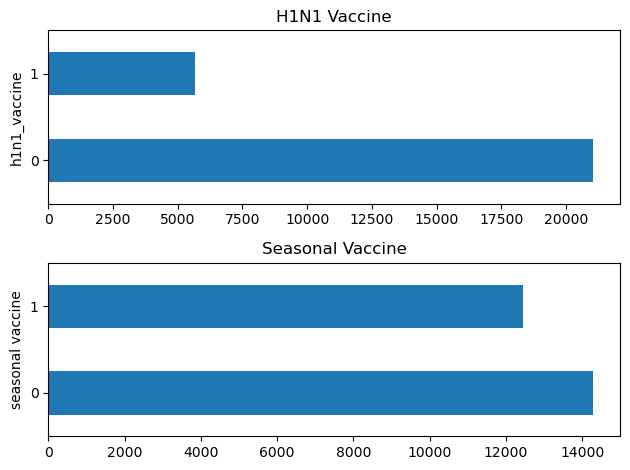

In [7]:
# class balance of target data

fig, ax = plt.subplots(2, 1)


#H1N1 
train_targets_1['h1n1_vaccine'].value_counts().plot.barh(title="H1N1 Vaccine", ax=ax[0])
ax[0].set_ylabel("h1n1_vaccine")

#Seasonal Vaccine
train_targets_1['seasonal_vaccine'].value_counts().plot.barh(title="Seasonal Vaccine", ax=ax[1])
ax[1].set_ylabel("seasonal vaccine")

fig.tight_layout()

# as we can see, the flu vaccine values are pretty balanced, but h1n1 vaccines are highly imbalanced. will have to
# take account of this in our modeling. 

In [8]:
# explore nulls
train_features_1.isna().sum()


# setting nulls to be less than 5% if we're going to delete them.

lower_threshold_percentage = 0.0

upper_threshold_percentage = 0.05

# Null ratios for each column
null_percentages = train_features_1.isnull().sum() / len(train_features_1)
print(null_percentages)
filtered_columns = null_percentages[
    (null_percentages > lower_threshold_percentage) & (null_percentages < upper_threshold_percentage)
].index.tolist()



respondent_id                  0.000000
h1n1_concern                   0.003445
h1n1_knowledge                 0.004343
behavioral_antiviral_meds      0.002658
behavioral_avoidance           0.007788
behavioral_face_mask           0.000711
behavioral_wash_hands          0.001573
behavioral_large_gatherings    0.003258
behavioral_outside_home        0.003070
behavioral_touch_face          0.004793
doctor_recc_h1n1               0.080878
doctor_recc_seasonal           0.080878
chronic_med_condition          0.036358
child_under_6_months           0.030704
health_worker                  0.030104
health_insurance               0.459580
opinion_h1n1_vacc_effective    0.014640
opinion_h1n1_risk              0.014528
opinion_h1n1_sick_from_vacc    0.014790
opinion_seas_vacc_effective    0.017299
opinion_seas_risk              0.019246
opinion_seas_sick_from_vacc    0.020107
age_group                      0.000000
education                      0.052683
race                           0.000000


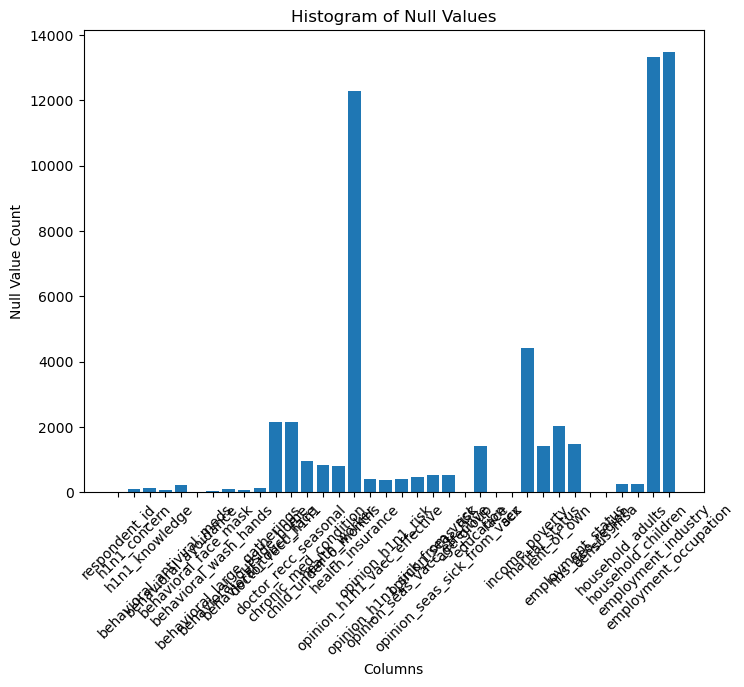

In [9]:
# let's visualize

null_counts = train_features_1.isnull().sum()

# Create a histogram of null values
plt.figure(figsize=(8, 6))
plt.bar(null_counts.index, null_counts.values)
plt.xlabel('Columns')
plt.ylabel('Null Value Count')
plt.title('Histogram of Null Values')
plt.xticks(rotation=45)
plt.show()





In [10]:
null_percentages_2 = test_features_1.isnull().sum() / len(train_features_1)

filtered_columns_2 = null_percentages_2 [
    (null_percentages_2  > lower_threshold_percentage) & (null_percentages_2  <= upper_threshold_percentage)
].index.tolist()


sorted(list(filtered_columns_2)) == sorted(list(filtered_columns))

# They're the same! So our training feature data is representative in respect to the nulls we can possibly drop.
# :et's go ahead and merge our training data, since we've established it's a represenative sample (relative to
# the other sample AKA test features)

True

## Merged EDA, Data Cleaning, and Train_test_split

In [11]:
# set indices
train_features_1 = train_features_1.set_index('respondent_id')
train_targets_1 = train_targets_1.set_index('respondent_id')

# merge

train_merged = train_features_1.merge(train_targets_1, on='respondent_id', how='inner')
train_merged.head()

train_merged.isna().sum()
train_merged.shape

(26707, 37)

In [12]:
train_merged.isna().sum()

# Drop null values from the filtered columns

merged_filtered = train_merged.dropna(subset=filtered_columns)
merged_filtered.head()
merged_filtered.shape
merged_filtered.isna().sum()

h1n1_concern                       0
h1n1_knowledge                     0
behavioral_antiviral_meds          0
behavioral_avoidance               0
behavioral_face_mask               0
behavioral_wash_hands              0
behavioral_large_gatherings        0
behavioral_outside_home            0
behavioral_touch_face              0
doctor_recc_h1n1                1827
doctor_recc_seasonal            1827
chronic_med_condition              0
child_under_6_months               0
health_worker                      0
health_insurance               10981
opinion_h1n1_vacc_effective        0
opinion_h1n1_risk                  0
opinion_h1n1_sick_from_vacc        0
opinion_seas_vacc_effective        0
opinion_seas_risk                  0
opinion_seas_sick_from_vacc        0
age_group                          0
education                        523
race                               0
sex                                0
income_poverty                  3284
marital_status                   522
r

In [13]:
# Let's look both at zero values and nulls

def zeroes_and_nulls(df):
    zeroes = (df == 0.00).astype(int).sum(axis=0)
    nulls = df.isnull().sum()
    nulls_percent = 100 * df.isnull().sum() / len(df)
    zero_nulls_table = pd.concat([zeroes, nulls, nulls_percent], axis=1)
    zero_nulls_table = zero_nulls_table.rename(
        columns = {0:'Zero Values',
                   1:'Missing Values',
                   2:'% Missing of Total Values'})
    zero_nulls_table['Total Zero or Missing Values'] = zero_nulls_table['Zero Values'] + zero_nulls_table['Missing Values']
    zero_nulls_table['% Total Zero or Missing Values'] = 100 * zero_nulls_table['Total Zero or Missing Values'] / len(df)
    zero_nulls_table['Data Type'] = df.dtypes
    zero_nulls_table = zero_nulls_table[zero_nulls_table.iloc[:,1] != 0].sort_values( '% Missing of Total Values', ascending=False).round(1)
    
    return zero_nulls_table



In [14]:
zeroes_and_nulls(merged_filtered)

,Zero Values,Missing Values,% Missing of Total Values,Total Zero or Missing Values,% Total Zero or Missing Values,Data Type
employment_occupation,0,11966,48.2,11966,48.2,object
employment_industry,0,11839,47.7,11839,47.7,object
health_insurance,1666,10981,44.3,12647,51.0,float64
income_poverty,0,3284,13.2,3284,13.2,object
doctor_recc_h1n1,17870,1827,7.4,19697,79.4,float64
doctor_recc_seasonal,15347,1827,7.4,17174,69.2,float64
rent_or_own,0,1108,4.5,1108,4.5,object
employment_status,0,571,2.3,571,2.3,object
education,0,523,2.1,523,2.1,object
marital_status,0,522,2.1,522,2.1,object


In [15]:
# hmmm, looks like we have even more columns with less than 5% nulls that we could maybe drop? 
# this indicates that certain null fields are correlated!

null_percentages_3 = merged_filtered.isnull().sum() / len(train_features_1)
filtered_columns_3 = null_percentages_3 [
    (null_percentages_3  > lower_threshold_percentage) & (null_percentages_3  <= upper_threshold_percentage)
].index.tolist()

# looking at how the null percentages changed after the first dropna. while I'm tempted to drop more, because
# of my concern about null correlations, I don't want to keep dropping and end up with very biased data

result = null_percentages_2[null_percentages_2.index.isin(null_percentages_3.index)] - null_percentages_3
print(result)

age_group                      0.000000
behavioral_antiviral_meds      0.002958
behavioral_avoidance           0.007975
behavioral_face_mask           0.000711
behavioral_large_gatherings    0.002696
behavioral_outside_home        0.003070
behavioral_touch_face          0.004793
behavioral_wash_hands          0.001498
census_msa                     0.000000
child_under_6_months           0.030441
chronic_med_condition          0.034897
doctor_recc_h1n1               0.012469
doctor_recc_seasonal           0.012469
education                      0.033100
employment_industry            0.053769
employment_occupation          0.054667
employment_status              0.033699
h1n1_concern                   0.003183
h1n1_knowledge                 0.004568
h1n1_vaccine                        NaN
health_insurance               0.046692
health_worker                  0.029543
hhs_geo_region                 0.000000
household_adults               0.008425
household_children             0.008425


In [16]:
# it also appears that the columns with zero values are likely simple binary classification.  let's look

print(merged_filtered.doctor_recc_h1n1.value_counts())
print(merged_filtered.doctor_recc_seasonal.value_counts())
print(merged_filtered.health_insurance.value_counts())

# yep, this clearly is the case with two of the columns full of zeroes. but what about health insurance? 
# it should be the same binary classifer, but why so many missing values? is it something that people would
# feel sensitive answering, like with specific information about employment? or maybe it's something to do with
# how the survey was structured? background info being towards the end, meaning the people who don't finish
# the survey would not provide this info? would be interesting to look at the survey itself. * did this and demographic
# questions were at the end, as i figured https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NIS/nhfs/nhfspuf_QUEX.PDF

0.0    17870
1.0     5106
Name: doctor_recc_h1n1, dtype: int64
0.0    15347
1.0     7629
Name: doctor_recc_seasonal, dtype: int64
1.0    12156
0.0     1666
Name: health_insurance, dtype: int64


In [17]:
#  maybe we're getting lost in the weeds. let's look at the profile report

sample = merged_filtered.sample(10000)

profile = ProfileReport(sample, minimal=True)
profile.to_file("output.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
# Looking at the profile report, we see our data is highly skewed/non-normal, on top of all 
# the missing (and likely missing-not-at-random (MNAR)) values. We should probably normalize some of the values? 

<AxesSubplot: >

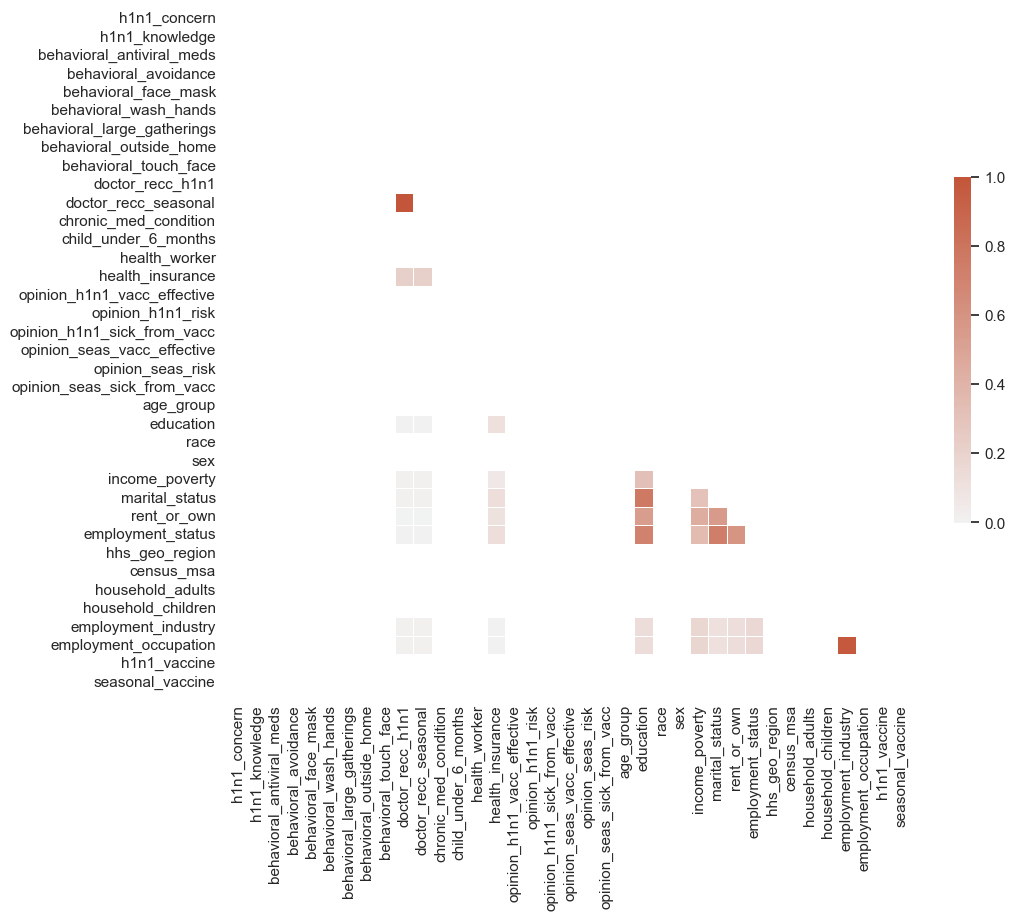

In [19]:
# Let's keep the missing data for now, especally since a good chunk of it appears MNAR 
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/

# We'll attempt to see statistically if the missing values are MNAR or not:

# R has something like this. Trying to find something in Python: https://rdrr.io/cran/finalfit/man/missing_pairs.html



sns.set_theme(style="white")



# Compute the correlation matrix
corr = merged_filtered.isnull().corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


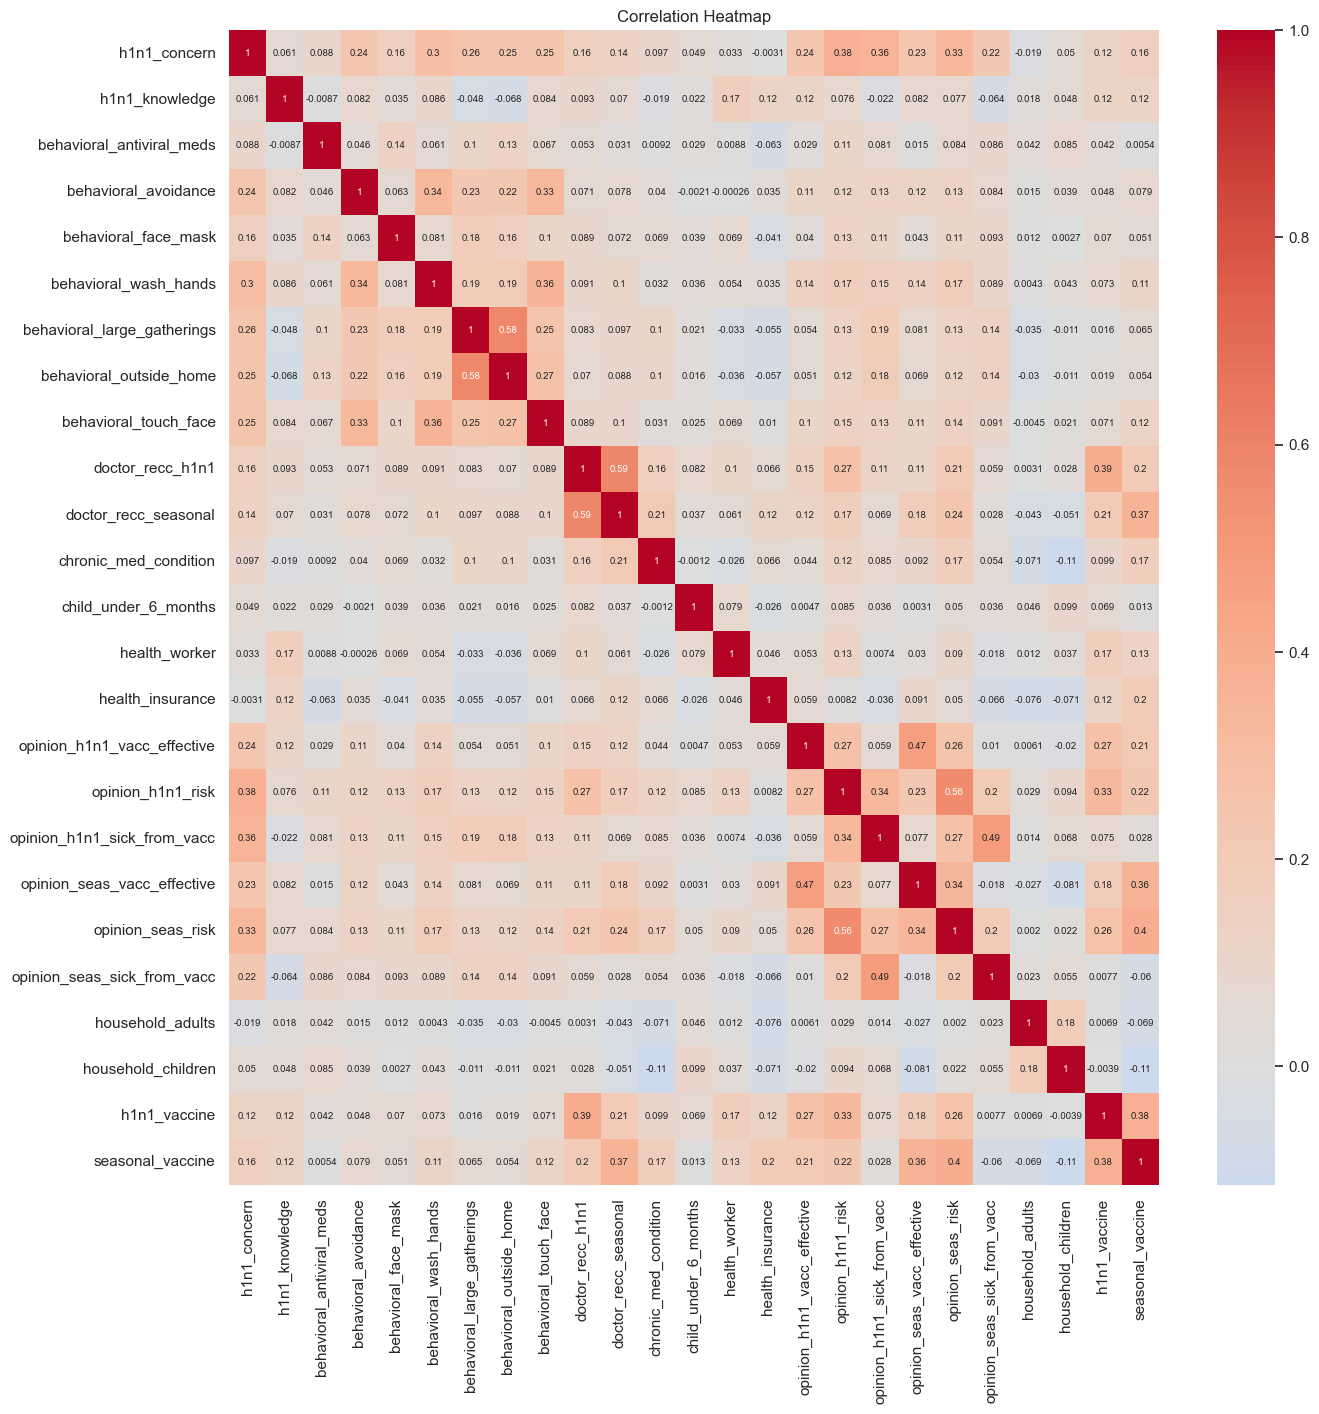

In [20]:
# hmmm, looks like the big employment category nulls are pretty strongly correlated with each other, and the health insurance 
# question is also moderately correlated with other nulls

# let's also look non-null correlated features and see if the same pattern applies?

corr = merged_filtered.corr()

# Plot heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr, center = 0, annot = True, annot_kws={"size": 35 / np.sqrt(len(corr))}, cmap = 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()


# well, this is interesting but doesn't. help us much with understanding the relationships between
# the big null categories. because the data type doesn't work with heatmaps 


In [21]:
# I think we've gone as far as we can go with understanding our nulls (at least for now). 

# Should we get rid of any collinear features? The "opininon" of risk columns are near .6, which is a typical
# threshhold for removal. Let's get a VIF score, which are often recommended over correlation scores.

y, X = dmatrices('h1n1_vaccine ~ opinion_h1n1_risk+opinion_seas_risk', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif



,VIF,variable
0,5.623849,Intercept
1,1.466893,opinion_h1n1_risk
2,1.466893,opinion_seas_risk


In [22]:
# More VIF scores for correlated features
y, X = dmatrices('h1n1_vaccine ~ doctor_recc_h1n1+doctor_recc_seasonal', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif


,VIF,variable
0,1.517967,Intercept
1,1.542967,doctor_recc_h1n1
2,1.542967,doctor_recc_seasonal


In [23]:
# Last VIF score for moderately correlated features
y, X = dmatrices('h1n1_vaccine ~ behavioral_outside_home+behavioral_large_gatherings', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,1.673572,Intercept
1,1.520031,behavioral_outside_home
2,1.520031,behavioral_large_gatherings


In [24]:
# None of our VIF scores are bad (1-5 is consdered moderate), 
# even though the heatmap suggests we should consider removing them. 

In [25]:
# Having handled nulls, multicollinearity, and zeroes (and briefly look at distributions), 
# let's also check out duplicates.

duplicates = merged_filtered[merged_filtered.duplicated()]
print(len(duplicates))


# No duplicates! cool! 

0


In [26]:
# Separating out data types for preprocessing

num_cols = []
cat_cols = []


for i in merged_filtered.columns:
    if merged_filtered[i].dtype in ['float64', 'int64']:
        num_cols.append(i)
    elif merged_filtered[i].dtype in ['object']:
        cat_cols.append(i)
    else:
        print("error")



In [27]:
# Setting X and Y, modifying data types

y = merged_filtered['h1n1_vaccine']


X = merged_filtered.drop('h1n1_vaccine', axis=1)

# Setting categorical column types
cats = X.select_dtypes('object').columns

X.loc[:,cats]  = X.loc[:,cats].astype('object')

# Removing our target variable from num_cols
num_cols.remove('h1n1_vaccine')

In [28]:

# Let's split the data!


# Really wanted to use this (Iterative_train_test_split), as it seems perfect, but it's too buggy and not enough documentation 

# from skmultilearn.model_selection import iterative_train_test_split
# http://videolectures.net/ecmlpkdd2011_tsoumakas_stratification/?q=stratification%20multi%20label
# was getting lots of errors. found solution here: https://github.com/scikit-multilearn/scikit-multilearn/issues/160

# This algorithm works for imbalanced multi-label target data
# X_train, y_train, X_test, y_test = iterative_train_test_split(
    #X.values,
    #y.values,
    #test_size = 0.2

X_train ,X_test, y_train, y_test = tts(X, y, test_size=0.25, random_state=42, shuffle=True, stratify=y)



In [29]:
# Simple transform pipeline

num_transformer = Pipeline(steps=[
    ('num_imputer', IterativeImputer(max_iter=100, random_state=42)),   # Iterative for imbalanced data 
    ('standard', StandardScaler())                                    
])

cat_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'))                     
])

In [30]:
# Simple preprocess 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols),
    ])



## MODEL 1: LogisticRegression

In [31]:
# Let's start out with a simple 'base' model for categorical data

logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('cat', LogisticRegression())
])

logreg.fit(X_train, y_train)

y_pred=logreg.predict(X_test)

logreg.score(X_train,y_train)

# ROC score not bad for a simple model!

0.8543704977959359

In [32]:
# Having a look at our coeffecients. Not every model I used had this or any kind of built-in feature importance, so this
# is one of two. 
logreg.steps[0][1].transformers_[1][1].steps[1][1].get_feature_names_out()

array(['x0_18 - 34 Years', 'x0_35 - 44 Years', 'x0_45 - 54 Years',
       'x0_55 - 64 Years', 'x0_65+ Years', 'x1_12 Years', 'x1_< 12 Years',
       'x1_College Graduate', 'x1_Some College', 'x1_Unknown', 'x2_Black',
       'x2_Hispanic', 'x2_Other or Multiple', 'x2_White', 'x3_Female',
       'x3_Male', 'x4_<= $75,000, Above Poverty', 'x4_> $75,000',
       'x4_Below Poverty', 'x4_Unknown', 'x5_Married', 'x5_Not Married',
       'x5_Unknown', 'x6_Own', 'x6_Rent', 'x6_Unknown', 'x7_Employed',
       'x7_Not in Labor Force', 'x7_Unemployed', 'x7_Unknown',
       'x8_atmpeygn', 'x8_bhuqouqj', 'x8_dqpwygqj', 'x8_fpwskwrf',
       'x8_kbazzjca', 'x8_lrircsnp', 'x8_lzgpxyit', 'x8_mlyzmhmf',
       'x8_oxchjgsf', 'x8_qufhixun', 'x9_MSA, Not Principle  City',
       'x9_MSA, Principle City', 'x9_Non-MSA', 'x10_Unknown',
       'x10_arjwrbjb', 'x10_atmlpfrs', 'x10_cfqqtusy', 'x10_dotnnunm',
       'x10_fcxhlnwr', 'x10_haxffmxo', 'x10_ldnlellj', 'x10_mcubkhph',
       'x10_mfikgejo', 'x10_msuuf

In [33]:
#  Creating a list with the corresponding onehot-encoded column names
names = ['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'x0_18 - 34 Years', 'x0_35 - 44 Years', 'x0_45 - 54 Years',
 'x0_55 - 64 Years', 'x0_65+ Years',
 'x1_12 Years', 'x1_< 12 Years',
 'x1_College Graduate', 'x1_Some College', 'x1_nan',
 'x2_Black', 'x2_Hispanic', 'x2_Other or Multiple', 'x2_White',
 'x3_Female', 'x3_Male',
 'x4_<= $75,000, Above Poverty', 'x4_> $75,000', 'x4_Below Poverty', 'x4_nan'
 'x5_Married', 'x5_Not Married', 'x5_nan',
 'x6_Own', 'x6_Rent', 'x6_nan',
 'x7_Employed', 'x7_Not in Labor Force', 'x7_Unemployed', 'x7_nan'
 'x8_bhuqouqj', 'x8_dqpwygqj', 'x8_fpwskwrf', 'x8_kbazzjca','x8_lrircsnp', 'x8_lzgpxyit', 'x8_mlyzmhmf',
 'x8_oxchjgsf','x8_qufhixun',
 'x9_MSA, Not Principle  City', 'x9_MSA, Principle City', 'x9_Non-MSA',
 'household_adults',
 'household_children',
 'x10_atmlpfrs', 'x10_cfqqtusy', 'x10_dotnnunm', 'x10_fcxhlnwr',
 'x10_haxffmxo', 'x10_ldnlellj', 'x10_mcubkhph', 'x10_mfikgejo',
 'x10_msuufmds', 'x10_nan', 'x10_nduyfdeo', 'x10_phxvnwax',
 'x11_bxpfxfdn', 'x11_ccgxvspp', 'x11_cmhcxjea',
 'x11_dcjcmpih', 'x11_dlvbwzss', 'x11_emcorrxb', 'x11_haliazsg',
 'x11_hfxkjkmi', 'x11_hodpvpew', 'x11_kldqjyjy', 'x11_mxkfnird',
 'x11_nan', 'x11_oijqvulv', 'x11_pvmttkik', 'x11_qxajmpny',
 'x11_rcertsgn', 'x11_tfqavkke', 'x11_ukymxvdu', 'x11_uqqtjvyb',
 'x11_vlluhbov', 'x11_xgwztkwe', 'x11_xqwwgdyp', 'x11_xtkaffoo',
 'x11_xzmlyyjv',
 'seasonal_vaccine']

In [34]:
# Creating a dataframe to view our coefficient data
coefs_1= logreg.steps[1][1].coef_
pd.DataFrame(zip(names, coefs_1[0])).sort_values(by =1 , ascending = False)

# Note the encoded data: CDC scrambled the employment categories, e.g. "x11_uqqtjvyb."


,0,1
23,x0_45 - 54 Years,0.975068
9,doctor_recc_h1n1,0.905418
93,x11_uqqtjvyb,0.830733
73,x10_nduyfdeo,0.830733
15,opinion_h1n1_vacc_effective,0.711906
78,x11_dcjcmpih,0.595298
16,opinion_h1n1_risk,0.503230
99,seasonal_vaccine,0.391542
86,x11_nan,0.349016
81,x11_haliazsg,0.270233


In [35]:
# Now that we have some features, let's start to further evaluate our model, and we can use these steps as a template

# Little function that returns our baseline scores

def evaluate(estimator, X_train, X_test, y_train, y_test):

    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)

    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"Train Precision: {precision_score(y_train, train_preds)}")
    print(f"Train Recall: {recall_score(y_train, train_preds)}")
    print(f"Train F1-Score: {f1_score(y_train, train_preds)}")
    
        
    print("*" * 10)
    print("Testing Scores:")
    print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"Test Precision: {precision_score(y_test, test_preds)}")
    print(f"Test Recall: {recall_score(y_test, test_preds)}")
    print(f"Test F1-Score: {f1_score(y_test, test_preds)}")
      
    

In [36]:
evaluate(logreg, X_train, X_test, y_train, y_test)

Training Scores:
Train Accuracy: 0.8543704977959359
Train Precision: 0.7097199341021416
Train Recall: 0.5409342039176294
Train F1-Score: 0.6139375801624626
**********
Testing Scores:
Test Accuracy: 0.8516368327689082
Test Precision: 0.7023809523809523
Test Recall: 0.5331325301204819
Test F1-Score: 0.6061643835616438


In [37]:
# The most important score here is the Test F1. This is true for imbalanced target data.

In [38]:

cross_validate(logreg, X_train, y_train, return_train_score=True)

{'fit_time': array([1.61903572, 1.69794083, 1.65591502, 1.78736305, 1.80624509]),
 'score_time': array([0.0293293 , 0.03172708, 0.03363705, 0.03282595, 0.03340101]),
 'test_score': array([0.84869659, 0.8452029 , 0.85215054, 0.85483871, 0.8516129 ]),
 'train_score': array([0.85505006, 0.85417647, 0.85519419, 0.85418627, 0.85398468])}

In [39]:
# Train and test scores aren't far apart, which is good. 

In [41]:
# Let's use a grid search to find our best hyperparameters. 

param_grid = {
    'cat__penalty': ['l1', 'l2', 'elasticnet', None],
    'cat__dual': [True, False],
    'cat__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}
              
              
grid_search_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv= 3,
    scoring='roc_auc'
)

grid_search_logreg.fit(X_test, y_test)

cv_score = grid_search_logreg.best_score_
test_score = roc_auc_score(y_test, grid_search_logreg.predict(X_test))

print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

# Our test score here is lower than with cross_validate, so it is apparently
# penalized more. Let's use this as our baseine.

Cross-validation score: 0.8649530709966914
Test score: 0.7410537903718301


In [42]:
# Best parameters for logreg
print(grid_search_logreg.best_params_)

{'cat__dual': False, 'cat__penalty': 'l1', 'cat__solver': 'liblinear'}


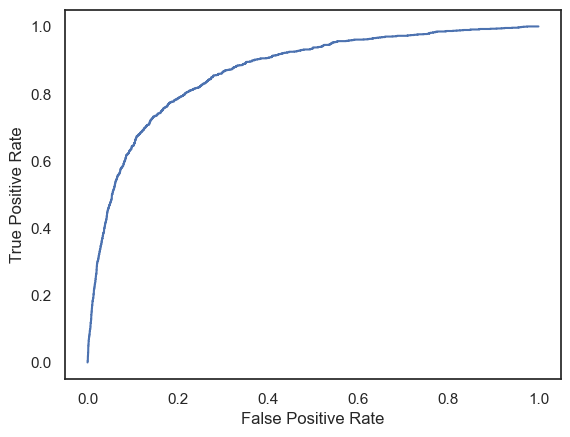

In [43]:

y_score = logreg.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=logreg.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [45]:
# applying smote to logreg 

from imblearn.pipeline import Pipeline as Pipeline_2
smote_1 = Pipeline_2([
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('cat', LogisticRegression())
])

smote_1.fit(X_train, y_train)
y_pred=smote_1.predict(X_test)
# Calculate the score on the resampled data
score = smote_1.score(X_train, y_train)
print("Score on resampled data:", score)

# Worse! Let's cross_validate this



Score on resampled data: 0.805719815073648


In [47]:
cross_validate(smote_1, X_train, y_train, return_train_score=True)

# We did worse!  

{'fit_time': array([1.852808  , 1.85557604, 1.87266994, 1.89181614, 1.88259697]),
 'score_time': array([0.0320611 , 0.03133488, 0.03266001, 0.03405595, 0.03134704]),
 'test_score': array([0.80650363, 0.79091642, 0.8077957 , 0.79919355, 0.80564516]),
 'train_score': array([0.80693502, 0.80915261, 0.80634323, 0.80432738, 0.80426018])}

In [50]:
# More logreg with SMOTE
evaluate(smote_1, X_train, X_test, y_train, y_test)

Training Scores:
Train Accuracy: 0.805719815073648
Train Precision: 0.5304434149569821
Train Recall: 0.8051230537418382
Train F1-Score: 0.6395372032714942
**********
Testing Scores:
Test Accuracy: 0.7972907595549105
Test Precision: 0.5177766649974962
Test Recall: 0.7786144578313253
Test F1-Score: 0.621954887218045


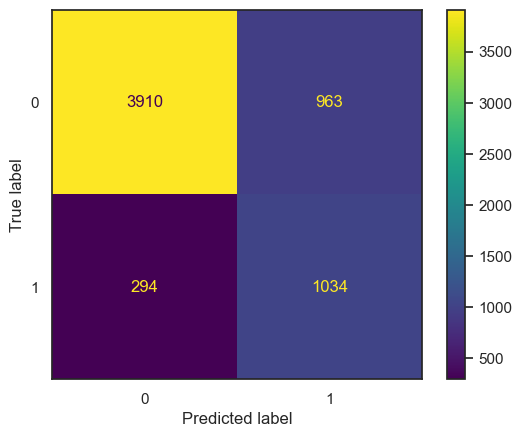

In [51]:
ConfusionMatrixDisplay.from_estimator(smote_1, X_test, y_test)

plt.show()

# Good at predicting true negatives, which are over-represented in the data. Terrible with true positives!

## MODEL 2: GradientBoostingClassifier

In [52]:

# Leveling up with a boosting classifier - GradientBoostingClassifier

gbc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cat', GradientBoostingClassifier(random_state=42))
])

gbc.fit(X_train, y_train)

y_pred=gbc.predict(X_test)

gbc.score(X_train,y_train)

# Better than logreg!

0.8752822277174498

In [56]:
evaluate(gbc, X_train, X_test, y_train, y_test)

Training Scores:
Train Accuracy: 0.8752822277174498
Train Precision: 0.7726377952755905
Train Recall: 0.5914113510798593
Train F1-Score: 0.6699857752489331
**********
Testing Scores:
Test Accuracy: 0.8701822286727947
Test Precision: 0.7586547972304649
Test Recall: 0.5775602409638554
Test F1-Score: 0.6558358272766139


In [57]:
cross_validate(gbc, X_train, y_train, return_train_score=True)

{'fit_time': array([6.8038311 , 6.74807501, 6.76482201, 6.83074093, 6.79579687]),
 'score_time': array([0.04122591, 0.04279613, 0.03829718, 0.04133463, 0.03913927]),
 'test_score': array([0.86697124, 0.86616501, 0.87392473, 0.87688172, 0.8672043 ]),
 'train_score': array([0.87863719, 0.87830119, 0.87757022, 0.87669668, 0.87703266])}

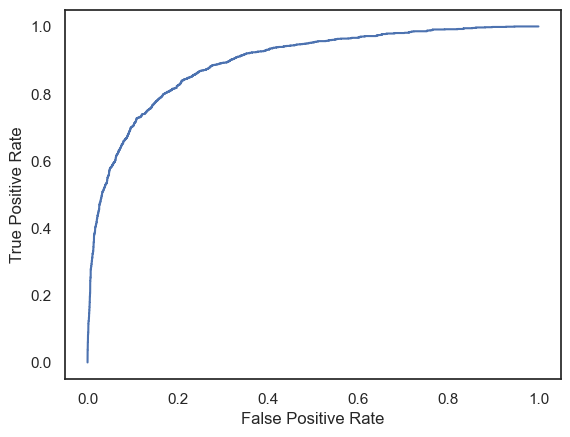

In [58]:

y_score = gbc.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=gbc.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# Looking better! Better scores all around!

In [59]:
# Trying SMOTE on gbc

smote_2 = Pipeline_2([
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('cat', GradientBoostingClassifier(random_state=42))
])

smote_2.fit(X_train, y_train)

score = smote_2.score(X_train, y_train)
print("Score on resampled data:", score)

# Didn't change much! A little worse this time for some reason. Maybe resampling adversely affects the boosting
# algorithm?

Score on resampled data: 0.8680787012149231


In [61]:
# Let's cross-validate on the SMOTED gbc

cross_validate(smote_2, X_train, y_train, return_train_score=True)

# These scores are also worse than with vanilla gbc

{'fit_time': array([15.21617293, 15.22775388, 15.24110508, 15.32892585, 15.13044286]),
 'score_time': array([0.03947592, 0.03900218, 0.04092288, 0.03840375, 0.03893709]),
 'test_score': array([0.86186509, 0.85702768, 0.86693548, 0.86854839, 0.86344086]),
 'train_score': array([0.87003562, 0.87050601, 0.86802849, 0.86742373, 0.86883483])}

In [64]:
# We're still getting decent results with this model, so might want to try a grid search
# Let's revert to the non-SMOTED pipeline 

param_grid = {
    'cat__learning_rate': [.3, .5, .7, .9],
    'cat__criterion': ['friedman_mse', 'squared_error'],
}
              
              
grid_search_gbc = GridSearchCV(
    estimator=gbc,  # pipeline 
    param_grid=param_grid,
    cv= 3,
    scoring='roc_auc'  # internal scoring term
)

grid_search_gbc.fit(X_test, y_test)

cv_score = grid_search_gbc.best_score_
test_score = roc_auc_score(y_test, grid_search_gbc.predict(X_test))

print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

# Test score is a large improvement over logreg! This is a pretty good model!

Cross-validation score: 0.8761564187522387
Test score: 0.8385255829391853


In [66]:
print(grid_search_gbc.best_params_)

{'cat__criterion': 'friedman_mse', 'cat__learning_rate': 0.3}


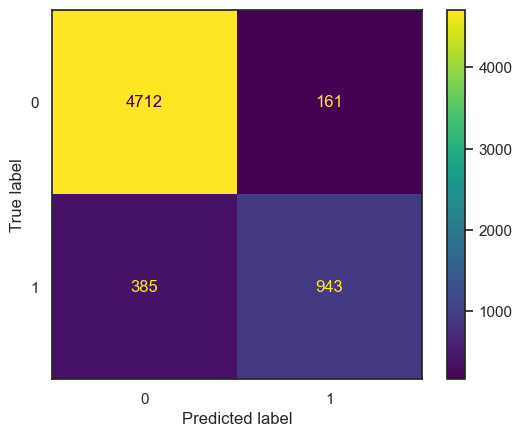

In [67]:
ConfusionMatrixDisplay.from_estimator(grid_search_gbc, X_test, y_test)

plt.show()

# This is really good with true negatives and true positives!

In [69]:
# We can actually do feature importance with this type of classifier, so let's use it.
# Can't do so from a GridSearch object, so have to plug in best parameters to the original moel
gbc_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cat', GradientBoostingClassifier(criterion='friedman_mse', learning_rate=.3, random_state=42))
])

gbc_2.fit(X_train, y_train)

y_pred=gbc_2.predict(X_test)



In [115]:
evaluate(gbc_2, X_train, X_test, y_train, y_test)

Training Scores:
Train Accuracy: 0.8881303085689711
Train Precision: 0.7958294428882664
Train Recall: 0.6421396283274736
Train F1-Score: 0.7107713690062543
**********
Testing Scores:
Test Accuracy: 0.8717948717948718
Test Precision: 0.7530864197530864
Test Recall: 0.5971385542168675
Test F1-Score: 0.6661066778664426


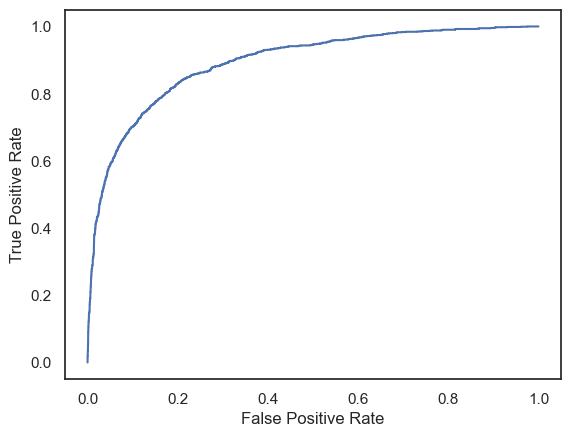

In [116]:
y_score = gbc_2.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=gbc_2.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [71]:
gbc_features = list(gbc_2['cat'].feature_importances_)

df = pd.DataFrame(list(zip(names, gbc_features)) )

# Sort the DataFrame by the 'Value' column in descending order
df_sorted = df.sort_values(by=1, ascending=False)

# Print the sorted DataFrame

print(df_sorted )

                               0         1
9               doctor_recc_h1n1  0.292372
23              x0_45 - 54 Years  0.218939
14              health_insurance  0.149277
16             opinion_h1n1_risk  0.109070
15   opinion_h1n1_vacc_effective  0.080927
10          doctor_recc_seasonal  0.036218
13                 health_worker  0.024536
73                  x10_nduyfdeo  0.007114
17   opinion_h1n1_sick_from_vacc  0.006224
20   opinion_seas_sick_from_vacc  0.003410
12          child_under_6_months  0.002980
18   opinion_seas_vacc_effective  0.002809
19             opinion_seas_risk  0.002519
34                      x2_White  0.002450
0                   h1n1_concern  0.002293
1                 h1n1_knowledge  0.001889
2      behavioral_antiviral_meds  0.001766
39              x4_Below Poverty  0.001711
28           x1_College Graduate  0.001657
72                       x10_nan  0.001573
7        behavioral_outside_home  0.001535
31                      x2_Black  0.001517
55         

## MODEL 3: HistGradientBoostingClassifier (Histogram-based)

In [72]:
# Trying a different kind of gradient boost that was recommended for this kind of data

hgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(loss='log_loss'))
])

hgb.fit(X_train, y_train)

y_pred=hgb.predict(X_test)

hgb.score(X_train,y_train)


# Wow! Best roc score yet!

0.8918933448016342

In [73]:
evaluate(hgb, X_train, X_test, y_train, y_test)

Training Scores:
Train Accuracy: 0.8918933448016342
Train Precision: 0.8098082364036466
Train Recall: 0.646911099949774
Train F1-Score: 0.7192517101772999
**********
Testing Scores:
Test Accuracy: 0.8674407353652637
Test Precision: 0.7423371647509579
Test Recall: 0.5835843373493976
Test F1-Score: 0.6534569983136593


In [75]:
cross_validate(hgb, X_train, y_train, return_train_score=True)

# Seems prone to overfitting, giving train and test divergences. Still, test scores are really good!

{'fit_time': array([2.22464108, 2.75464392, 2.70204806, 2.27563787, 2.35649514]),
 'score_time': array([0.0560987 , 0.05712414, 0.0594449 , 0.05232501, 0.05647278]),
 'test_score': array([0.86616501, 0.86294007, 0.8766129 , 0.87069892, 0.87284946]),
 'train_score': array([0.89187555, 0.90242591, 0.90310442, 0.8934283 , 0.89524257])}

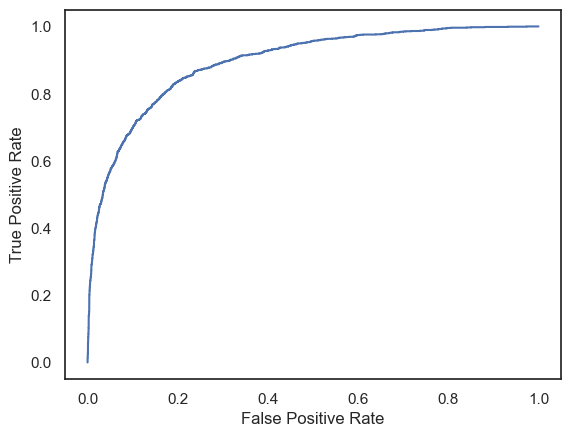

In [76]:
y_score = hgb.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=hgb.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


In [77]:
# Going to apply SMOTE to HistGradientBoostingClassifier()


smote_3 = Pipeline_2([
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('cat', HistGradientBoostingClassifier())
])

smote_3.fit(X_train, y_train)

# Calculate the score on the resampled data
score = smote_3.score(X_train, y_train)
print("Score on resampled data:", score)

# Not much of a change, but a slight improvement nonetheless

Score on resampled data: 0.8937748629179658


In [79]:
cross_validate(smote_3, X_train, y_train, return_train_score=True)

# Still prone to overfitting, but I'm still liking those test scores

{'fit_time': array([3.31187034, 3.33560514, 3.38406587, 3.31460094, 3.22422719]),
 'score_time': array([0.06006789, 0.06106591, 0.06186891, 0.05926228, 0.05774379]),
 'test_score': array([0.86804622, 0.86428379, 0.87311828, 0.87473118, 0.8688172 ]),
 'train_score': array([0.89758753, 0.90067872, 0.89793039, 0.89793039, 0.89826636])}

0.8947475207623021

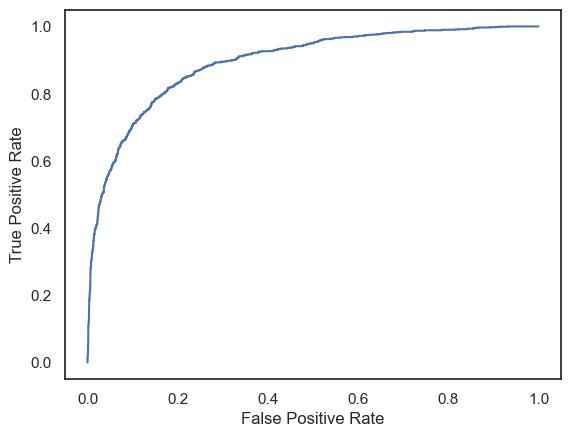

In [91]:
y_scores = smote_3.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=smote_3.classes_[1])


roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

auc = roc_auc_score(y_test, y_scores)
auc

# We are still seeing really good scores with this model!  Let's try a grid search!


In [96]:
test_score = roc_auc_score(y_test, smote_3.predict(X_test))
print(test_score)  # this is the test score that penalizes the most, so let's use it. Would like to know more about
#these metrics, though.

0.7714846405939787


In [81]:
# GridSearch SMOTE HistBoost

param_grid = {
    'cat__learning_rate': [.1, .3, .5, .7, 1],
    'cat__max_iter': [10, 50, 100],
    'cat__max_depth': [3,5,7]
}
              
              
grid_search_smote_3 = GridSearchCV(
    estimator=smote_3,
    param_grid=param_grid,
    cv= 3,
    scoring='roc_auc'
)

grid_search_smote_3.fit(X_test, y_test)

cv_score = grid_search_smote_3.best_score_
test_score = roc_auc_score(y_test, grid_search_smote_3.predict(X_test))

print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')



Cross-validation score: 0.8819961265107091
Test score: 0.8014974169198856


In [82]:
print(grid_search_smote_3.best_params_)

{'cat__learning_rate': 0.3, 'cat__max_depth': 3, 'cat__max_iter': 50}


In [84]:
# Applying best tuning parameters to our second-best model:

smote_4 = Pipeline_2([
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('cat', HistGradientBoostingClassifier(max_depth=3, learning_rate=.3, max_iter=50))
])

smote_4.fit(X_train, y_train)

# Calculate the score on the resampled data
score = smote_4.score(X_train, y_train)
print("Score on resampled data:", score)

Score on resampled data: 0.8717342221266531


In [85]:
cross_validate(smote_4, X_train, y_train, return_train_score=True)

{'fit_time': array([2.05471516, 2.05630302, 2.04362392, 2.153337  , 2.15684986]),
 'score_time': array([0.05309272, 0.05254769, 0.05213118, 0.0537169 , 0.05565786]),
 'test_score': array([0.86455254, 0.8613276 , 0.86908602, 0.86908602, 0.86854839]),
 'train_score': array([0.8753444 , 0.87688999, 0.87206021, 0.87293375, 0.87609192])}

0.8885050771524431

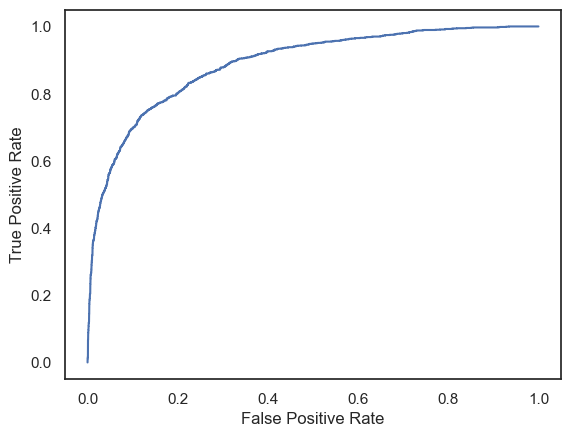

In [86]:
y_scores = smote_4.decision_function(X_test) 

fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=smote_4.classes_[1])


roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

auc = roc_auc_score(y_test, y_scores)
auc

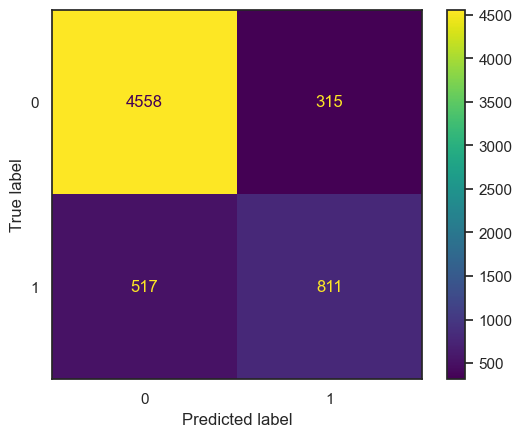

In [87]:
ConfusionMatrixDisplay.from_estimator(smote_4, X_test, y_test)

plt.show()

# Worse confusion matrix than our GradientBoost model 

In [ ]:
# Let's look at this model's coefficients or feature selections (if we can!)
# aaand we can't with hgb. isn't supported! 


In [88]:
evaluate(smote_4, X_train, X_test, y_train, y_test)

Training Scores:
Train Accuracy: 0.8717342221266531
Train Precision: 0.734982332155477
Train Recall: 0.6268206931190357
Train F1-Score: 0.6766061263214963
**********
Testing Scores:
Test Accuracy: 0.8658280922431866
Test Precision: 0.7202486678507993
Test Recall: 0.6106927710843374
Test F1-Score: 0.660961695191524


In [ ]:
# Well, We should stick with GradientBoostingClassifer. Try one more model?

## MODEL 4: CatBoostClassifier

In [98]:
# Last model, CatBoostClassifier!


cbc = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", CatBoostClassifier(iterations=10,learning_rate=.7,depth=7, verbose=False))
])

cbc.fit(X_train, y_train)

y_pred = cbc.predict(X_test)

cbc.score(X_train, y_train)

# from the website:
# Tree depth
# In most cases, the optimal depth ranges from 4 to 10. Values in the range from 6 to 10 are recommended.

# Note

# The maximum depth of the trees is limited to 8 for pairwise modes 
# (YetiRank, PairLogitPairwise and QueryCrossEntropy) when the training is performed on GPU.



0.8813030856897108

In [99]:
cross_validate(cbc, X_train, y_train, return_train_score=True)



{'fit_time': array([2.07826805, 2.14370513, 2.14685321, 2.07238603, 2.1344142 ]),
 'score_time': array([0.15343404, 0.15433693, 0.15104389, 0.16494012, 0.16926694]),
 'test_score': array([0.86562752, 0.86159635, 0.86639785, 0.86532258, 0.86774194]),
 'train_score': array([0.88555877, 0.88602916, 0.88025803, 0.88106437, 0.88455853])}

In [100]:
auc = roc_auc_score(y_test, y_scores)
auc

0.8947475207623021

In [102]:
# SMOTE with CatBoost
smote_5 = Pipeline_2([
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('cat', CatBoostClassifier(iterations = 10, learning_rate =.7, depth = 7, verbose = False))
])

smote_5.fit(X_train, y_train)

# Calculate the score on the resampled data
score = smote_5.score(X_train, y_train)
print("Score on resampled data:", score)

# Resampling did not help us, but maybe it reduced overfitting?

Score on resampled data: 0.8743145898290506


In [103]:

cross_validate(smote, X_train, y_train, return_train_score=True)

{'fit_time': array([2.70956492, 2.7117579 , 2.78839707, 2.73137283, 2.71848702]),
 'score_time': array([0.15822816, 0.17446399, 0.16535282, 0.15862894, 0.15543914]),
 'test_score': array([0.86616501, 0.85998388, 0.86532258, 0.86532258, 0.86290323]),
 'train_score': array([0.8764196 , 0.87843559, 0.87313533, 0.87629351, 0.87535278])}

In [105]:
# Un-SMOTEd Catboost

cbc_2 = Pipeline_2([
    ("preprocessor", preprocessor),
    ('cat', CatBoostClassifier(iterations = 10, learning_rate =.7, depth = 7, verbose = False))
])

cbc_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('standard',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavi...
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('cat',
                 <catboost.core.CatBoostClassifier object at 0x123617090>)])

In [106]:
# GridSearch with un-SMOTEd CatBoost

param_grid = {'cat__depth': [3,5,6,8,10],
             'cat__learning_rate': [.3,.5,.7,1]}


grid_search_cbc_2 = GridSearchCV(
    estimator=cbc_2,
    param_grid=param_grid,
    cv= 3,
    scoring='roc_auc'
)

grid_search_cbc_2.fit(X_test, y_test)


cv_score = grid_search_cbc_2.best_score_
test_score = roc_auc_score(y_test, grid_search_cbc_2.predict(X_test))

print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

# Test score is not good. Was worth a shot!

Cross-validation score: 0.8825863242500915
Test score: 0.767335425222334


In [107]:
evaluate(cbc_2, X_train, X_test, y_train, y_test)

Training Scores:
Train Accuracy: 0.8813030856897108
Train Precision: 0.7808739708676378
Train Recall: 0.6192867905575088
Train F1-Score: 0.6907563025210084
**********
Testing Scores:
Test Accuracy: 0.865021770682148
Test Precision: 0.7349282296650718
Test Recall: 0.5783132530120482
Test F1-Score: 0.6472819216182047


In [108]:
evaluate(smote_5, X_train, X_test, y_train, y_test)

Training Scores:
Train Accuracy: 0.8743145898290506
Train Precision: 0.7393709959231217
Train Recall: 0.6376192867905575
Train F1-Score: 0.6847357065803668
**********
Testing Scores:
Test Accuracy: 0.865021770682148
Test Precision: 0.7159190853122251
Test Recall: 0.6129518072289156
Test F1-Score: 0.6604462474645031


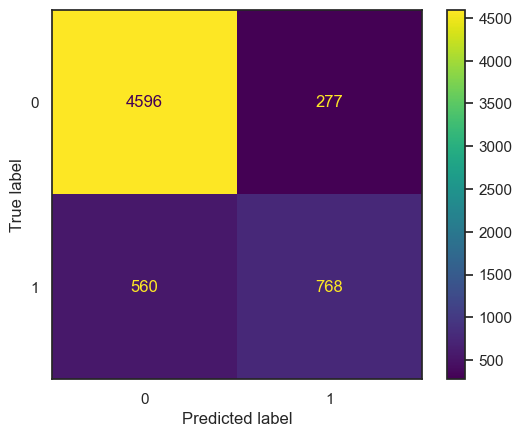

In [109]:
ConfusionMatrixDisplay.from_estimator(cbc_2, X_test, y_test)

plt.show()

# Good at predicting true negatives, which are over-represented in the data. Terrible with true positives!

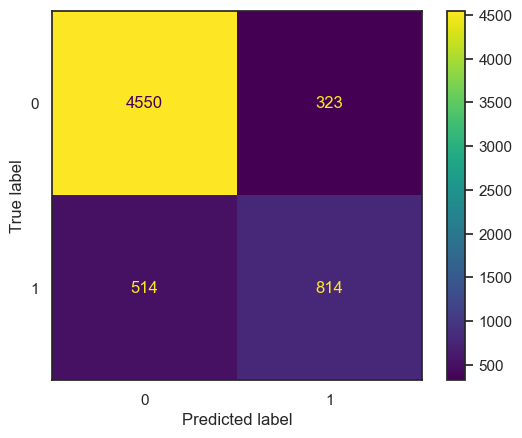

In [110]:
ConfusionMatrixDisplay.from_estimator(smote_5, X_test, y_test)

plt.show()


In [ ]:
# Hard to tell whether SMOTEd or un-SMOTEd CatBoost is better? Scores kinda all over the place.

In [ ]:
# Functions for visualizations

def make_stacked_chart(df, col, vaccine):
    df_grouped = pd.DataFrame(df.groupby(col)[vaccine].value_counts())
    df_grouped.columns = ['count']
    df_grouped = df_grouped.reset_index()
    
    pivot_df = df_grouped.pivot(index=[col], columns=vaccine, values=['count']).reset_index()
    
    pivot_df.set_index(col).plot(kind='bar', stacked=True, color=['steelblue', 'darkorange'])
    plt.title(f'Stacked Bar Chart {col}')
    plt.legend(['Non-vaccinated', 'Vaccinated'])
    plt.ylabel('Count')
    plt.show()
    
def make_group_barcharts(df, col_list, nrows, ncols, vaccine, tight=False, figx=16, figy=36):
    fig = plt.figure(figsize=(figx, figy))

    for i, col in enumerate(col_list):
        ax = plt.subplot(nrows, ncols, i+1)
        df_grouped = pd.DataFrame(df.groupby(col)[vaccine].value_counts())
        df_grouped.columns = ['count']
        df_grouped = df_grouped.reset_index()
    
        pivot_df = df_grouped.pivot(index=[col], columns=vaccine, values=['count']).reset_index()
    
        pivot_df.set_index(col).plot(kind='bar', stacked=True, color=['steelblue', 'darkorange'], ax = ax)
        plt.title(f'Stacked Bar Chart {col}')
        plt.legend(['Non-vaccinated', 'Vaccinated'])
        plt.ylabel('Count')
        
    if tight:
        plt.tight_layout()

In [ ]:
# Stacked bar charts for our best features
make_stacked_chart(merged_filtered, 'age_group', 'h1n1_vaccine')
make_stacked_chart(merged_filtered, 'opinion_h1n1_vacc_effective', 'h1n1_vaccine')
make_stacked_chart(merged_filtered, 'doctor_recc_h1n1', 'h1n1_vaccine')
make_stacked_chart(merged_filtered, 'health_insurance', 'h1n1_vaccine')
make_stacked_chart(merged_filtered, 'opinion_h1n1_risk', 'h1n1_vaccine')

# x0_45 - 54 Years	0.391556
# 10	doctor_recc_seasonal	0.029098
# 18	opinion_seas_vacc_effective	0.017172
# 64	x10_cfqqtusy	0.011919
# 40	x4_nanx5_Married	0.010823
# 60	x9_Non-MSA	0.010343

In [ ]:
# Stacked bar charts for our least least impactful features
make_stacked_chart(merged_filtered, 'employment_status', 'h1n1_vaccine') # not in labor force
make_stacked_chart(merged_filtered, 'sex', 'h1n1_vaccine') # men 
make_stacked_chart(merged_filtered, 'household_children', 'h1n1_vaccine') # any kids in house
make_stacked_chart(merged_filtered, 'chronic_med_condition', 'h1n1_vaccine') 


In [ ]:
# show off the curve differences of our models
#grid_search.fit(X_train, y_train)

# need to go back and rename some variables here and get the graph



# # Plot the ROC curve using RocCurveDisplay
# roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
# fig, ax = plt.subplots(figsize=(10, 10))
# RocCurveDisplay(fpr=fpr, tpr=tpr,
#                name='Logistic Regssion', ax=ax),
# RocCurveDisplay(fpr=fpr, tpr=tpr,
#                name='Gradient Boosting Classifier', ax=ax)
# RocCurveDisplay(fpr=fpr, tpr=tpr, 
#                name='Histogram-based Gradient Boosting Classifer', ax=ax)
# RocCurveDisplay(fpr=fpr, tpr=tpr,
#                name='Categorical Boosting Classifer', ax=ax);

# plt.show()

In [ ]:
# (had done feature selection before with XGBoost Classifer (which I now can't get to work) and it returned 
# Doctor Recommends as # 1

In [ ]:
# gonna come back to this later

# from sklearn.multioutput import MultiOutputClassifier
# y_train 
# moc = Pipeline([
#     ("preprocessor", preprocessor),
#     ("estimators", MultiOutputClassifier(estimator=LogisticRegression()))
# ])

# moc.fit(X_train, y_train)

# y_pred = moc.predict(X_test)

# moc.score(X_train, y_train)


# error: y must have at least two dimensions for multi-output regression but has only one.

# for shits and giggles, let's re-define 7 just for this case


In [ ]:
# mlb = MultiLabelBinarizer()
# y_train_binarized = mlb.fit_transform(y_train)
# y_test_binarized = mlb.fit_transform(y_test)

# save this for a later date, when we want to predit multilabel data. a lot of models don't accept these. vectorized type does.

In [ ]:
# from catboost.utils import get_roc_curve
# catboost_pool = Pool(X_train, y_train)
# smote.fit(X_train, y_train, verbose=False)
# (fpr, tpr, thresholds) = get_roc_curve(smote, catboost_pool, plot=True)
# print(fpr)
# print(tpr)
# print(thresholds)

# need to clean up this mixed data to use this 
# error: CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=21]="65+ Years": Cannot convert 'b'65+ Years'' to float


In [ ]:
# look at later

# grid_search.cv_results_